# Data Engineering and Visualization

In [76]:
import pandas as pd
import numpy as np
import glob
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [77]:
csv_files = glob.glob('*.csv')
csv_files

['USDCHF=X.csv', 'USDEUR=X.csv', 'USDGBP=X.csv']

In [78]:
#personal preference
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']

In [79]:
df_train=[]
df_test=[]
df_raw=[]
for path in filepath:
    df_temp=pd.read_csv(path)
    #We no longer need date, because we can use index.
    df_temp=df_temp[['Close']]
    df_temp.columns=['rate']
    # Somehow USDCHF=X.csv has one more day 2023/11/4, which shouldn't exist.
    if (path=='USDCHF=X.csv'):
        df_temp.drop(df_temp.index[-1], inplace=True)
    df_raw.append(df_temp)
    df_train.append(df_temp[:-5])
    df_test.append(df_temp[-5:])

In [82]:
for i in range(3):
    print(len(df_raw[i]))

2610
2610
2610


In [5]:
# There is something wrong with the files downloaded from the website.
# These rows shouldn't be nan.
# In this case, we simply adopt a strategy of dropping these rows.
# 2017/7/11 2017/11/16 2019/5/22
for i in range(len(filepath)):
    rows_with_nan = df_train[0][df_train[0].isna().any(axis=1)].index
    print(rows_with_nan)
for i in range(len(filepath)):
    df_train[i]=df_train[i].dropna()

Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')
Index([961, 1053, 1447], dtype='int64')


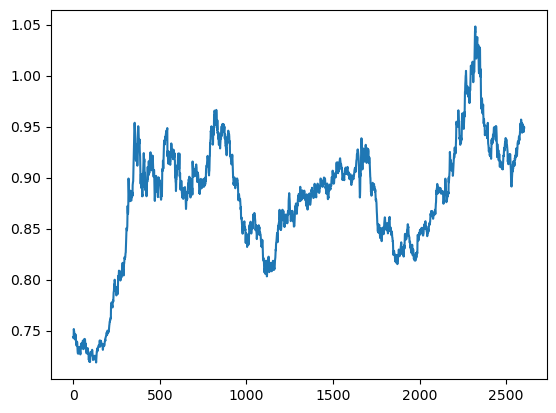

In [6]:
plt.plot(np.array(df_train[0].index),np.array(df_train[0])[:])

In [7]:
def test_stationarity(timeseries):
    # execute Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    print(f'p-value={dftest[1]}')

In [8]:
# First order difference is enough to make timeseries stationary, beacuase p-value<0.05. 
for i in range(len(filepath)):
    print(f"{i}:")
    test_stationarity(df_train[i]['rate'])
    #test first-order difference
    test_stationarity(df_train[i]['rate'].diff().dropna())

0:
p-value=0.21601996022016906
p-value=0.0
1:
p-value=0.3209845178253695
p-value=0.0
2:
p-value=0.053530464485031466
p-value=0.0


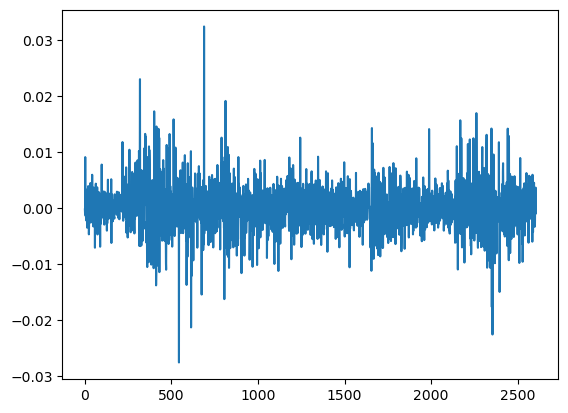

In [9]:
# By utilizing first order difference, we have made the timeseries stationary
plt.plot(df_train[0].diff().dropna())

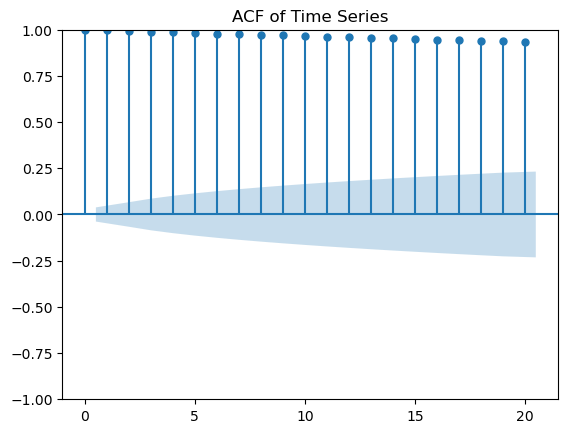

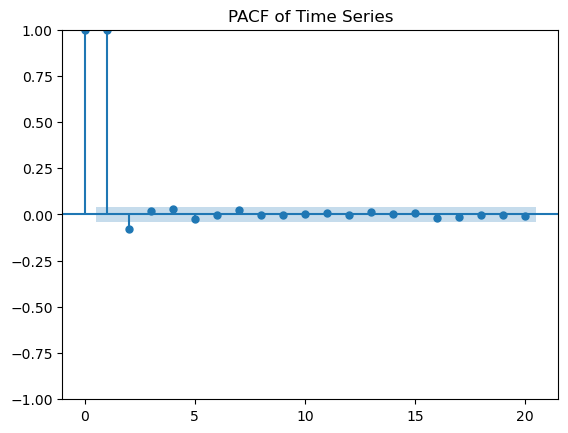

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# plot ACF figure
plot_acf(df_train[0], lags=20)
plt.title('ACF of Time Series')
plt.show()

# plot PACF figure
plot_pacf(df_train[0], lags=20)
plt.title('PACF of Time Series')
plt.show()

# Prophet

In [11]:
!pip3 install prophet 
!pip3 install --upgrade plotly
!pip3 install pandas_market_calendars
!pip3 install --upgrade pandas
from prophet import Prophet
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [12]:
# As prophet needs datetime and numeric value as input, I will re-process the input data here
filepath=['USDEUR=X.csv','USDGBP=X.csv','USDCHF=X.csv']
df_train_prophet=[]
df_test_prophet=[]
df_all_prophet = []
for path in filepath:
    df_temp=pd.read_csv(path)[["Date", "High"]] # keep both Date and High
    df_temp = df_temp.rename(columns={"Date": "ds", "High": "y"})
    df_train_prophet.append(df_temp[:-5])
    df_test_prophet.append(df_temp[-5:])
    df_all_prophet.append(df_temp)

In [13]:
df_train_prophet[0]

,ds,y
0,2013-11-04,0.743770
1,2013-11-05,0.743510
2,2013-11-06,0.742460
3,2013-11-07,0.751552
4,2013-11-08,0.750677
...,...,...
2600,2023-10-23,0.945910
2601,2023-10-24,0.944800
2602,2023-10-25,0.946360
2603,2023-10-26,0.950000


In [14]:
df_test_prophet[0]

,ds,y
2605,2023-10-30,0.94801
2606,2023-10-31,0.94629
2607,2023-11-01,0.95031
2608,2023-11-02,0.94480
2609,2023-11-03,0.94202


In [15]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet()
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

21:01:25 - cmdstanpy - INFO - Chain [1] start processing
21:01:26 - cmdstanpy - INFO - Chain [1] done processing
21:01:26 - cmdstanpy - INFO - Chain [1] start processing
21:01:26 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
prophet_models[0][1]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-10-30,0.959745,0.937011,0.993399,0.959745,0.959745,0.003372,0.003372,0.003372,-0.000739,-0.000739,-0.000739,0.004111,0.004111,0.004111,0.0,0.0,0.0,0.963117
1,2023-10-31,0.959813,0.936033,0.991557,0.959813,0.959813,0.003975,0.003975,0.003975,-0.000566,-0.000566,-0.000566,0.004541,0.004541,0.004541,0.0,0.0,0.0,0.963788
2,2023-11-01,0.959882,0.939691,0.991405,0.959882,0.959882,0.004414,0.004414,0.004414,-0.000585,-0.000585,-0.000585,0.004999,0.004999,0.004999,0.0,0.0,0.0,0.964295
3,2023-11-02,0.959950,0.938809,0.992135,0.959950,0.959950,0.005225,0.005225,0.005225,-0.000250,-0.000250,-0.000250,0.005475,0.005475,0.005475,0.0,0.0,0.0,0.965175
4,2023-11-03,0.960018,0.937253,0.993321,0.960018,0.960018,0.005803,0.005803,0.005803,-0.000161,-0.000161,-0.000161,0.005964,0.005964,0.005964,0.0,0.0,0.0,0.965822


## Calculate Errors For Prediction

In [17]:
errors = []
def calculate_mse(truth, prediction):
    """ 
    truth, prediction: 5x5 array, predictions for the next 5 trading days for 5 curves 
    """
    errors = [np.mean(np.square(truth[i] - prediction)) for i in range(len(truth))]
    return errors, np.sum(errors)

calculate_mse([df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))], [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))])

([0.0034678570831605015, 0.010102703406414788, 0.0023839275206320684],
 0.01595448801020736)

## Plot the ground truth and prediction

In [18]:
def draw_pred_truth(truth, pred):
    fig, axes = plt.subplots(1, len(truth), figsize=(30, 10))
    for i in range(len(filepath)):
        ax = axes[i]
        ax.plot(truth[i], label='Truth')
        ax.plot(pred[i], label='Pred')
        ax.set_title(f'Plot {i + 1}')
        ax.legend()
        ax.grid()
    plt.tight_layout()
    plt.show()

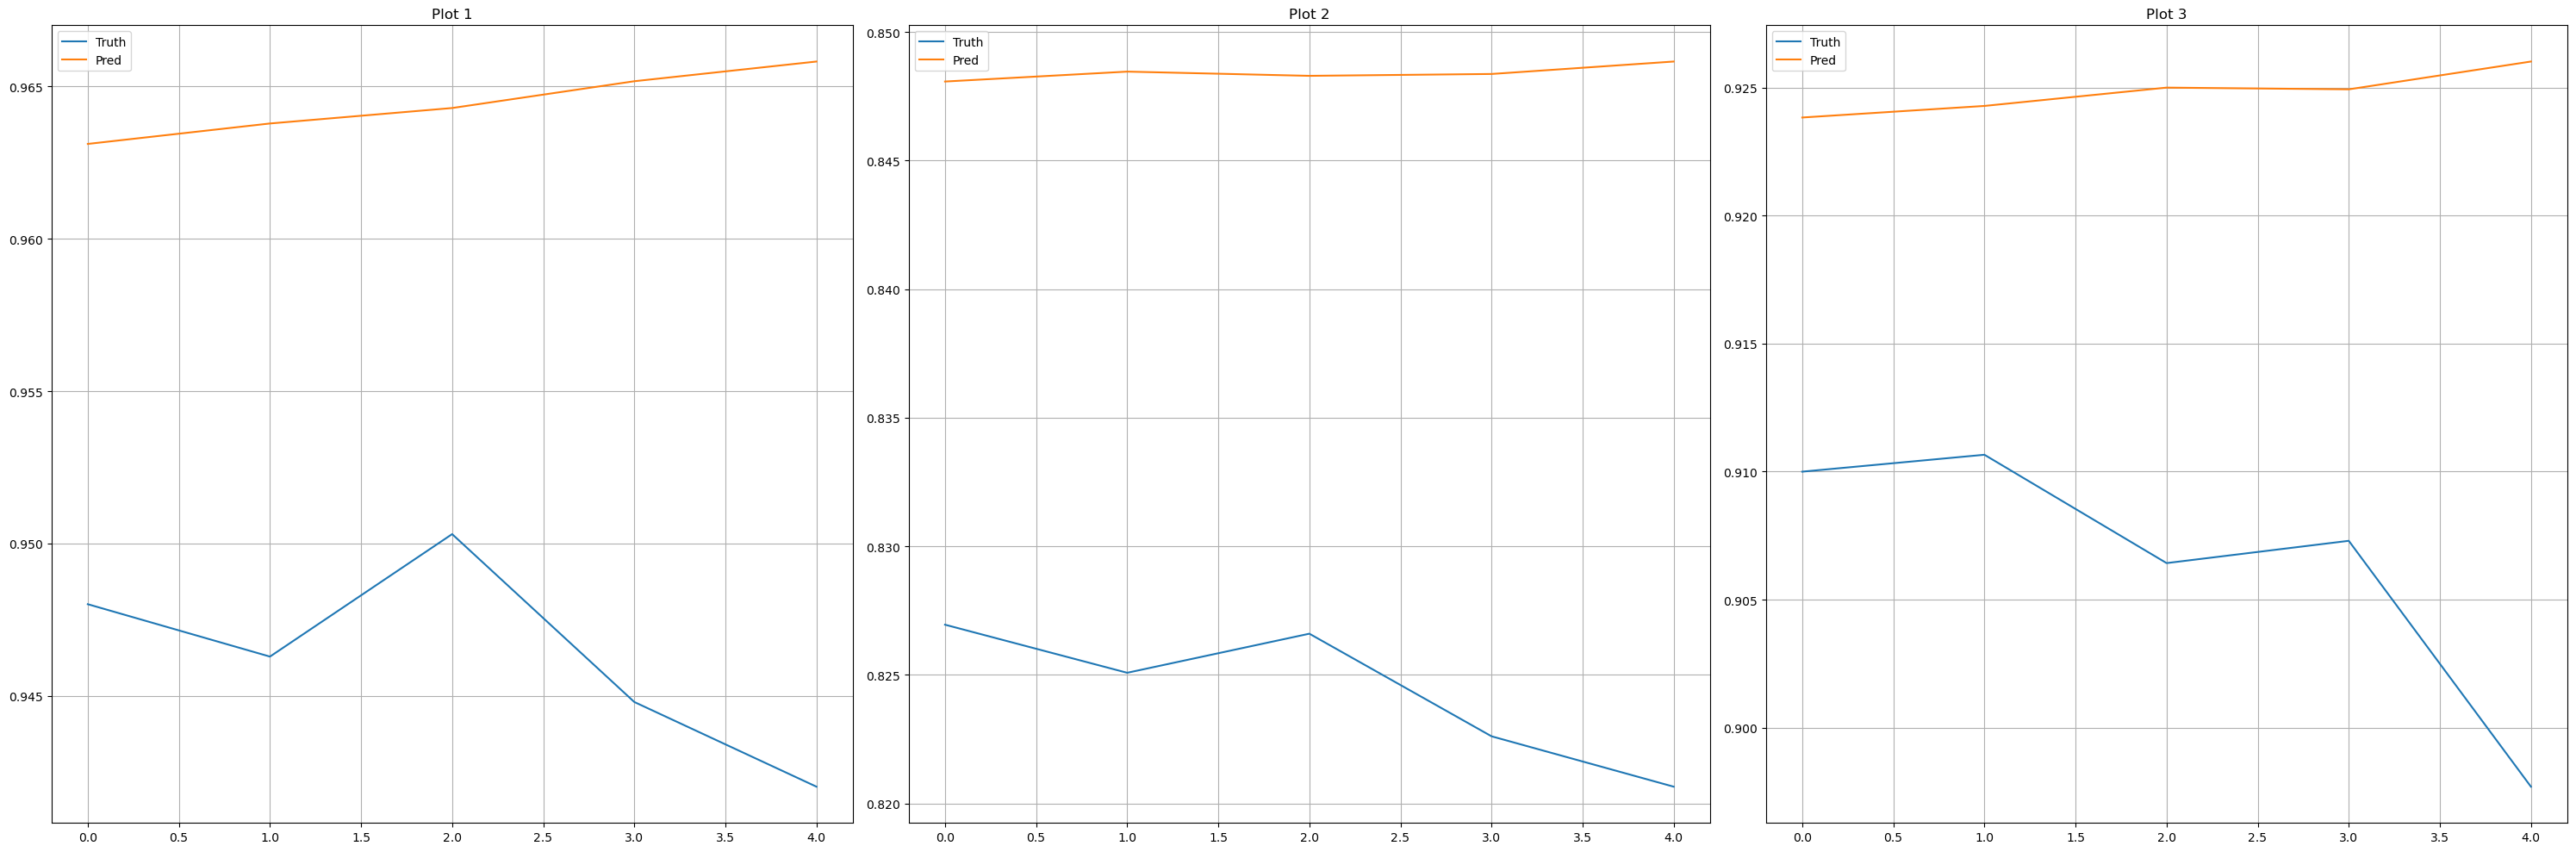

In [19]:
truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

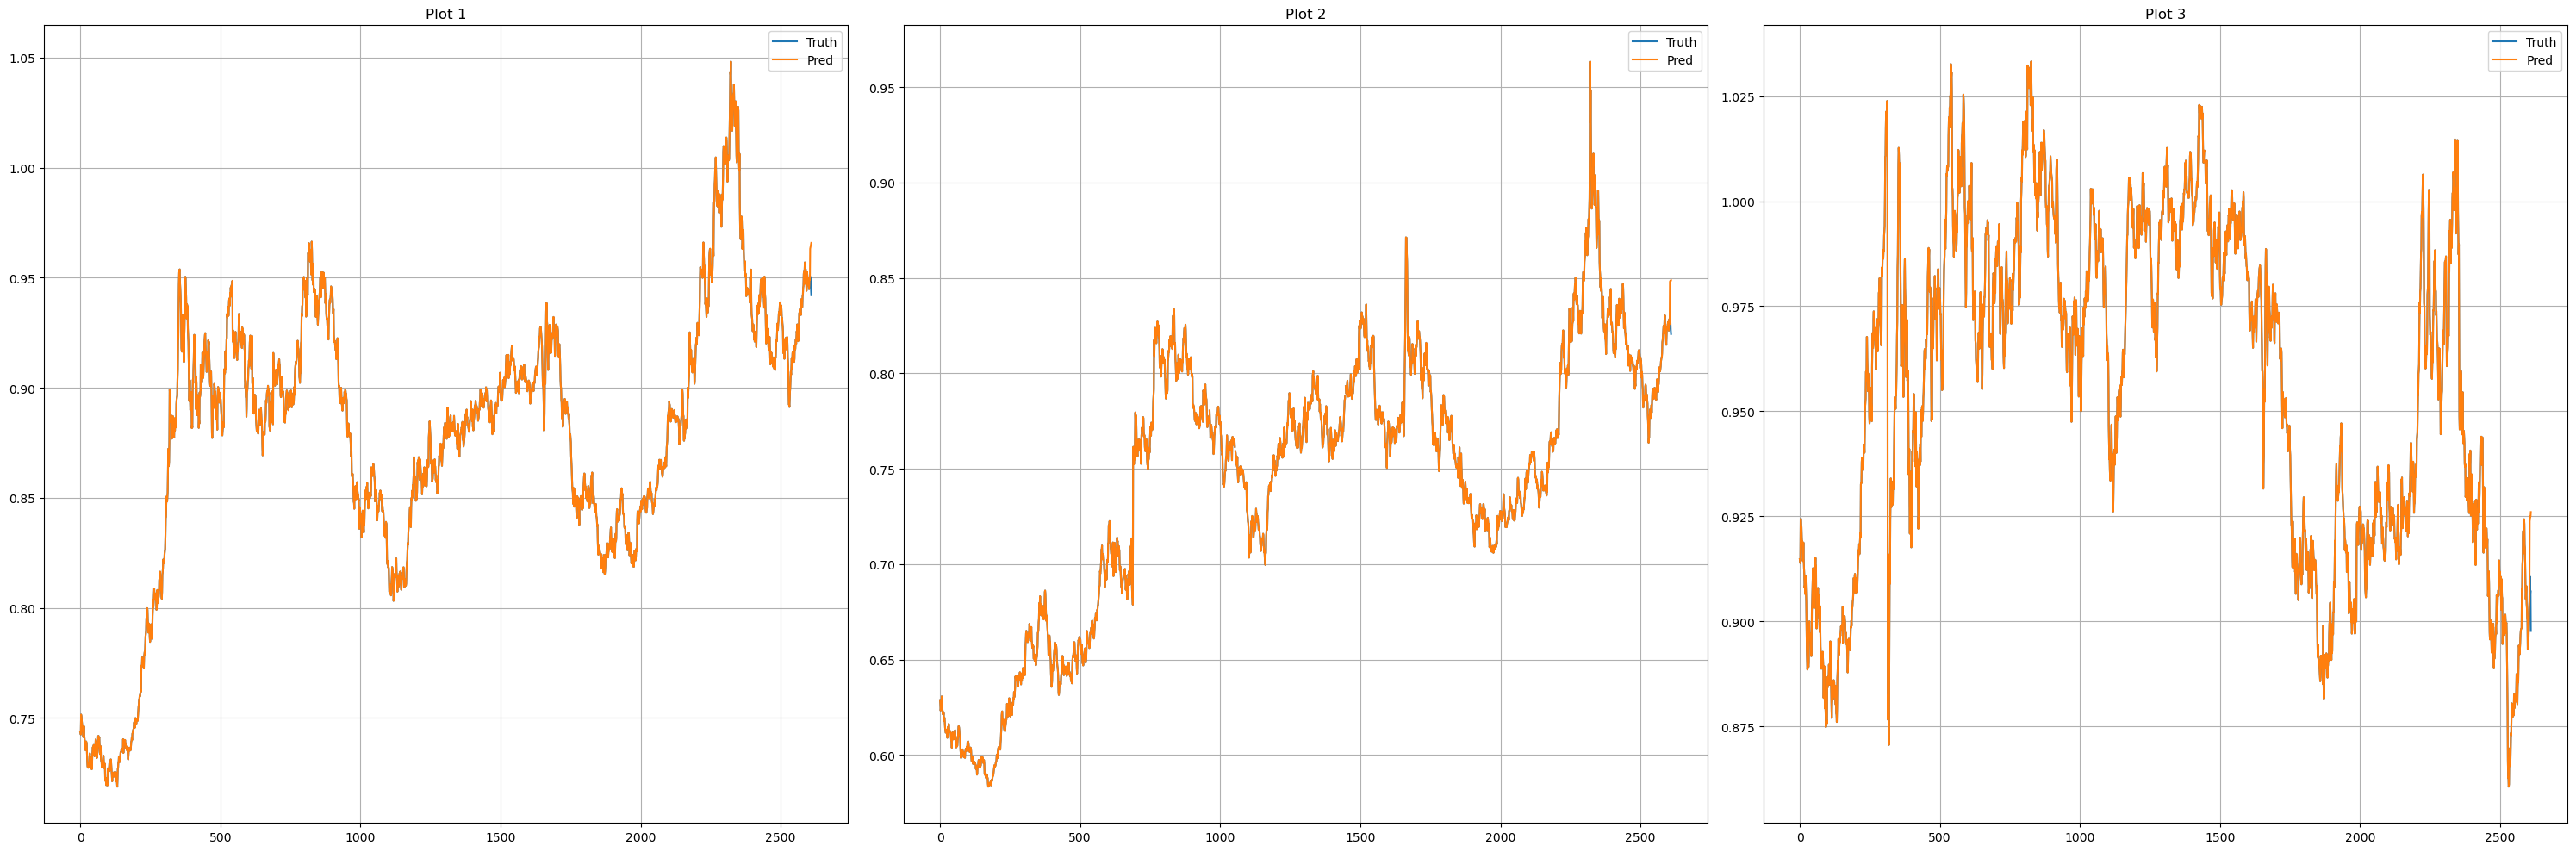

In [20]:
train_pred_prophet = [np.concatenate((df_train_prophet[i]['y'].to_numpy(), prophet_models[i][1]['yhat'].to_numpy()), axis=0) for i in range(len(df_train_prophet))]
# print(len(train_pred_prophet))
draw_pred_truth([df_all_prophet[i]['y'].to_numpy() for i in range(len(df_all_prophet))], train_pred_prophet)

## Hyper parameter tunning to find the best model

In [21]:
# Define a range of hyperparameter values to search
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1], # default 0.05
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10], # default 10
}
best_mse = float('inf')
best_params = {}
ground_truth = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]

# Iterate through the parameter grid and find the best hyperparameters
for params in ParameterGrid(param_grid):
    print(f"params is {params}")
    para_models = []
    for curve_data in df_train_prophet:
        # Create a Prophet model with the current hyperparameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale']
        )
        
        # Fit the model on the training data
        model.fit(curve_data)
        
        last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
        # Create a date range for the next 5 trading days, excluding weekends
        future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
        # Create a DataFrame with these dates
        future_df = pd.DataFrame({'ds': future_dates})
        # Make predictions
        forecast = model.predict(future_df)

        para_models.append((model, forecast))
    _, mse = calculate_mse(ground_truth, [para_models[i][1]['yhat'].to_numpy() for i in range(len(para_models))])
    print(f"MSE is {mse}")
    # Check if the current set of hyperparameters results in a better model
    if mse < best_mse:
        best_mse = mse
        best_params = params

print("Best Hyperparameters:")
print(best_params)
print("Best MSE:", best_mse)

21:01:28 - cmdstanpy - INFO - Chain [1] start processing


params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing
21:01:29 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


21:01:29 - cmdstanpy - INFO - Chain [1] done processing
21:01:29 - cmdstanpy - INFO - Chain [1] start processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:30 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


21:01:30 - cmdstanpy - INFO - Chain [1] done processing
21:01:31 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing
21:01:31 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing
21:01:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


21:01:31 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


21:01:33 - cmdstanpy - INFO - Chain [1] done processing
21:01:33 - cmdstanpy - INFO - Chain [1] start processing
21:01:33 - cmdstanpy - INFO - Chain [1] done processing
21:01:33 - cmdstanpy - INFO - Chain [1] start processing
21:01:33 - cmdstanpy - INFO - Chain [1] done processing
21:01:34 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


21:01:34 - cmdstanpy - INFO - Chain [1] done processing
21:01:34 - cmdstanpy - INFO - Chain [1] start processing
21:01:34 - cmdstanpy - INFO - Chain [1] done processing
21:01:34 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing
21:01:35 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


21:01:35 - cmdstanpy - INFO - Chain [1] done processing
21:01:35 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing
21:01:36 - cmdstanpy - INFO - Chain [1] start processing
21:01:36 - cmdstanpy - INFO - Chain [1] done processing
21:01:36 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


21:01:36 - cmdstanpy - INFO - Chain [1] done processing
21:01:36 - cmdstanpy - INFO - Chain [1] start processing
21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - INFO - Chain [1] start processing
21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:38 - cmdstanpy - INFO - Chain [1] start processing
21:01:38 - cmdstanpy - INFO - Chain [1] done processing
21:01:38 - cmdstanpy - INFO - Chain [1] start processing
21:01:38 - cmdstanpy - INFO - Chain [1] done processing
21:01:38 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


21:01:39 - cmdstanpy - INFO - Chain [1] done processing
21:01:39 - cmdstanpy - INFO - Chain [1] start processing
21:01:39 - cmdstanpy - INFO - Chain [1] done processing
21:01:39 - cmdstanpy - INFO - Chain [1] start processing
21:01:39 - cmdstanpy - INFO - Chain [1] done processing
21:01:40 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


21:01:40 - cmdstanpy - INFO - Chain [1] done processing
21:01:40 - cmdstanpy - INFO - Chain [1] start processing
21:01:40 - cmdstanpy - INFO - Chain [1] done processing
21:01:40 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:42 - cmdstanpy - INFO - Chain [1] start processing
21:01:42 - cmdstanpy - INFO - Chain [1] done processing
21:01:42 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


21:01:42 - cmdstanpy - INFO - Chain [1] done processing
21:01:42 - cmdstanpy - INFO - Chain [1] start processing
21:01:43 - cmdstanpy - INFO - Chain [1] done processing
21:01:43 - cmdstanpy - INFO - Chain [1] start processing
21:01:43 - cmdstanpy - INFO - Chain [1] done processing
21:01:43 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018836529198180615
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


21:01:43 - cmdstanpy - INFO - Chain [1] done processing
21:01:43 - cmdstanpy - INFO - Chain [1] start processing
21:01:44 - cmdstanpy - INFO - Chain [1] done processing
21:01:44 - cmdstanpy - INFO - Chain [1] start processing
21:01:44 - cmdstanpy - INFO - Chain [1] done processing
21:01:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018820339220951998
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


21:01:45 - cmdstanpy - INFO - Chain [1] done processing
21:01:45 - cmdstanpy - INFO - Chain [1] start processing
21:01:45 - cmdstanpy - INFO - Chain [1] done processing
21:01:45 - cmdstanpy - INFO - Chain [1] start processing
21:01:45 - cmdstanpy - INFO - Chain [1] done processing
21:01:45 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0187562842807555
params is {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


21:01:46 - cmdstanpy - INFO - Chain [1] done processing
21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:46 - cmdstanpy - INFO - Chain [1] done processing
21:01:46 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.018794031107938324
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:48 - cmdstanpy - INFO - Chain [1] done processing
21:01:48 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing
21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:53 - cmdstanpy - INFO - Chain [1] done processing
21:01:53 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


21:01:54 - cmdstanpy - INFO - Chain [1] done processing
21:01:54 - cmdstanpy - INFO - Chain [1] start processing
21:01:54 - cmdstanpy - INFO - Chain [1] done processing
21:01:54 - cmdstanpy - INFO - Chain [1] start processing
21:01:55 - cmdstanpy - INFO - Chain [1] done processing
21:01:55 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


21:01:55 - cmdstanpy - INFO - Chain [1] done processing
21:01:55 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing
21:01:56 - cmdstanpy - INFO - Chain [1] start processing
21:01:56 - cmdstanpy - INFO - Chain [1] done processing
21:01:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


21:01:57 - cmdstanpy - INFO - Chain [1] done processing
21:01:57 - cmdstanpy - INFO - Chain [1] start processing
21:01:58 - cmdstanpy - INFO - Chain [1] done processing
21:01:58 - cmdstanpy - INFO - Chain [1] start processing
21:01:58 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
21:02:01 - cmdstanpy - INFO - Chain [1] done processing
21:02:01 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:02 - cmdstanpy - INFO - Chain [1] start processing
21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:02 - cmdstanpy - INFO - Chain [1] start processing
21:02:02 - cmdstanpy - INFO - Chain [1] done processing
21:02:03 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


21:02:03 - cmdstanpy - INFO - Chain [1] done processing
21:02:03 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:04 - cmdstanpy - INFO - Chain [1] start processing
21:02:04 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:06 - cmdstanpy - INFO - Chain [1] done processing
21:02:06 - cmdstanpy - INFO - Chain [1] start processing
21:02:06 - cmdstanpy - INFO - Chain [1] done processing
21:02:07 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


21:02:07 - cmdstanpy - INFO - Chain [1] done processing
21:02:07 - cmdstanpy - INFO - Chain [1] start processing
21:02:08 - cmdstanpy - INFO - Chain [1] done processing
21:02:08 - cmdstanpy - INFO - Chain [1] start processing
21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:09 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


21:02:09 - cmdstanpy - INFO - Chain [1] done processing
21:02:10 - cmdstanpy - INFO - Chain [1] start processing
21:02:10 - cmdstanpy - INFO - Chain [1] done processing
21:02:10 - cmdstanpy - INFO - Chain [1] start processing
21:02:10 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:12 - cmdstanpy - INFO - Chain [1] done processing
21:02:12 - cmdstanpy - INFO - Chain [1] start processing
21:02:12 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015998175347751532
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


21:02:13 - cmdstanpy - INFO - Chain [1] done processing
21:02:13 - cmdstanpy - INFO - Chain [1] start processing
21:02:14 - cmdstanpy - INFO - Chain [1] done processing
21:02:14 - cmdstanpy - INFO - Chain [1] start processing
21:02:14 - cmdstanpy - INFO - Chain [1] done processing
21:02:15 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015926536286644984
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


21:02:15 - cmdstanpy - INFO - Chain [1] done processing
21:02:15 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:17 - cmdstanpy - INFO - Chain [1] done processing
21:02:17 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015935961994793395
params is {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


21:02:17 - cmdstanpy - INFO - Chain [1] done processing
21:02:18 - cmdstanpy - INFO - Chain [1] start processing
21:02:18 - cmdstanpy - INFO - Chain [1] done processing
21:02:18 - cmdstanpy - INFO - Chain [1] start processing
21:02:18 - cmdstanpy - INFO - Chain [1] done processing
21:02:19 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.01595448801020736
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


21:02:19 - cmdstanpy - INFO - Chain [1] done processing
21:02:19 - cmdstanpy - INFO - Chain [1] start processing
21:02:20 - cmdstanpy - INFO - Chain [1] done processing
21:02:20 - cmdstanpy - INFO - Chain [1] start processing
21:02:21 - cmdstanpy - INFO - Chain [1] done processing
21:02:21 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:23 - cmdstanpy - INFO - Chain [1] done processing
21:02:24 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


21:02:25 - cmdstanpy - INFO - Chain [1] done processing
21:02:25 - cmdstanpy - INFO - Chain [1] start processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing
21:02:26 - cmdstanpy - INFO - Chain [1] start processing
21:02:26 - cmdstanpy - INFO - Chain [1] done processing
21:02:26 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 10}


21:02:27 - cmdstanpy - INFO - Chain [1] done processing
21:02:27 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:29 - cmdstanpy - INFO - Chain [1] done processing
21:02:29 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


21:02:30 - cmdstanpy - INFO - Chain [1] done processing
21:02:30 - cmdstanpy - INFO - Chain [1] start processing
21:02:30 - cmdstanpy - INFO - Chain [1] done processing
21:02:30 - cmdstanpy - INFO - Chain [1] start processing
21:02:31 - cmdstanpy - INFO - Chain [1] done processing
21:02:31 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


21:02:32 - cmdstanpy - INFO - Chain [1] done processing
21:02:32 - cmdstanpy - INFO - Chain [1] start processing
21:02:33 - cmdstanpy - INFO - Chain [1] done processing
21:02:33 - cmdstanpy - INFO - Chain [1] start processing
21:02:34 - cmdstanpy - INFO - Chain [1] done processing
21:02:34 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:36 - cmdstanpy - INFO - Chain [1] done processing
21:02:36 - cmdstanpy - INFO - Chain [1] start processing
21:02:36 - cmdstanpy - INFO - Chain [1] done processing
21:02:37 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 10}


21:02:37 - cmdstanpy - INFO - Chain [1] done processing
21:02:37 - cmdstanpy - INFO - Chain [1] start processing
21:02:38 - cmdstanpy - INFO - Chain [1] done processing
21:02:38 - cmdstanpy - INFO - Chain [1] start processing
21:02:39 - cmdstanpy - INFO - Chain [1] done processing
21:02:39 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.01}


21:02:40 - cmdstanpy - INFO - Chain [1] done processing
21:02:40 - cmdstanpy - INFO - Chain [1] start processing
21:02:40 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}


21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:43 - cmdstanpy - INFO - Chain [1] done processing
21:02:43 - cmdstanpy - INFO - Chain [1] start processing
21:02:44 - cmdstanpy - INFO - Chain [1] done processing
21:02:44 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 1.0}


21:02:45 - cmdstanpy - INFO - Chain [1] done processing
21:02:45 - cmdstanpy - INFO - Chain [1] start processing
21:02:46 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:47 - cmdstanpy - INFO - Chain [1] done processing
21:02:47 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 10}


21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:49 - cmdstanpy - INFO - Chain [1] start processing
21:02:49 - cmdstanpy - INFO - Chain [1] done processing
21:02:49 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015336799486973127
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.01}


21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015314405839860004
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 0.1}


21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:54 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.015295367119741509
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 1.0}


21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:56 - cmdstanpy - INFO - Chain [1] done processing
21:02:56 - cmdstanpy - INFO - Chain [1] start processing
21:02:57 - cmdstanpy - INFO - Chain [1] done processing
21:02:57 - cmdstanpy - INFO - Chain [1] start processing


MSE is 0.0153086028135619
params is {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 10, 'seasonality_prior_scale': 10}


21:02:58 - cmdstanpy - INFO - Chain [1] done processing
21:02:58 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing
21:02:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:59 - cmdstanpy - INFO - Chain [1] done processing


MSE is 0.015336799486973127
Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
Best MSE: 0.015295367119741509


In [22]:
# Best Hyperparameters:
# {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}
# Best MSE: 0.07732153857925472

## Now predict using the best model 

21:03:00 - cmdstanpy - INFO - Chain [1] start processing
21:03:00 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:01 - cmdstanpy - INFO - Chain [1] done processing
21:03:01 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing


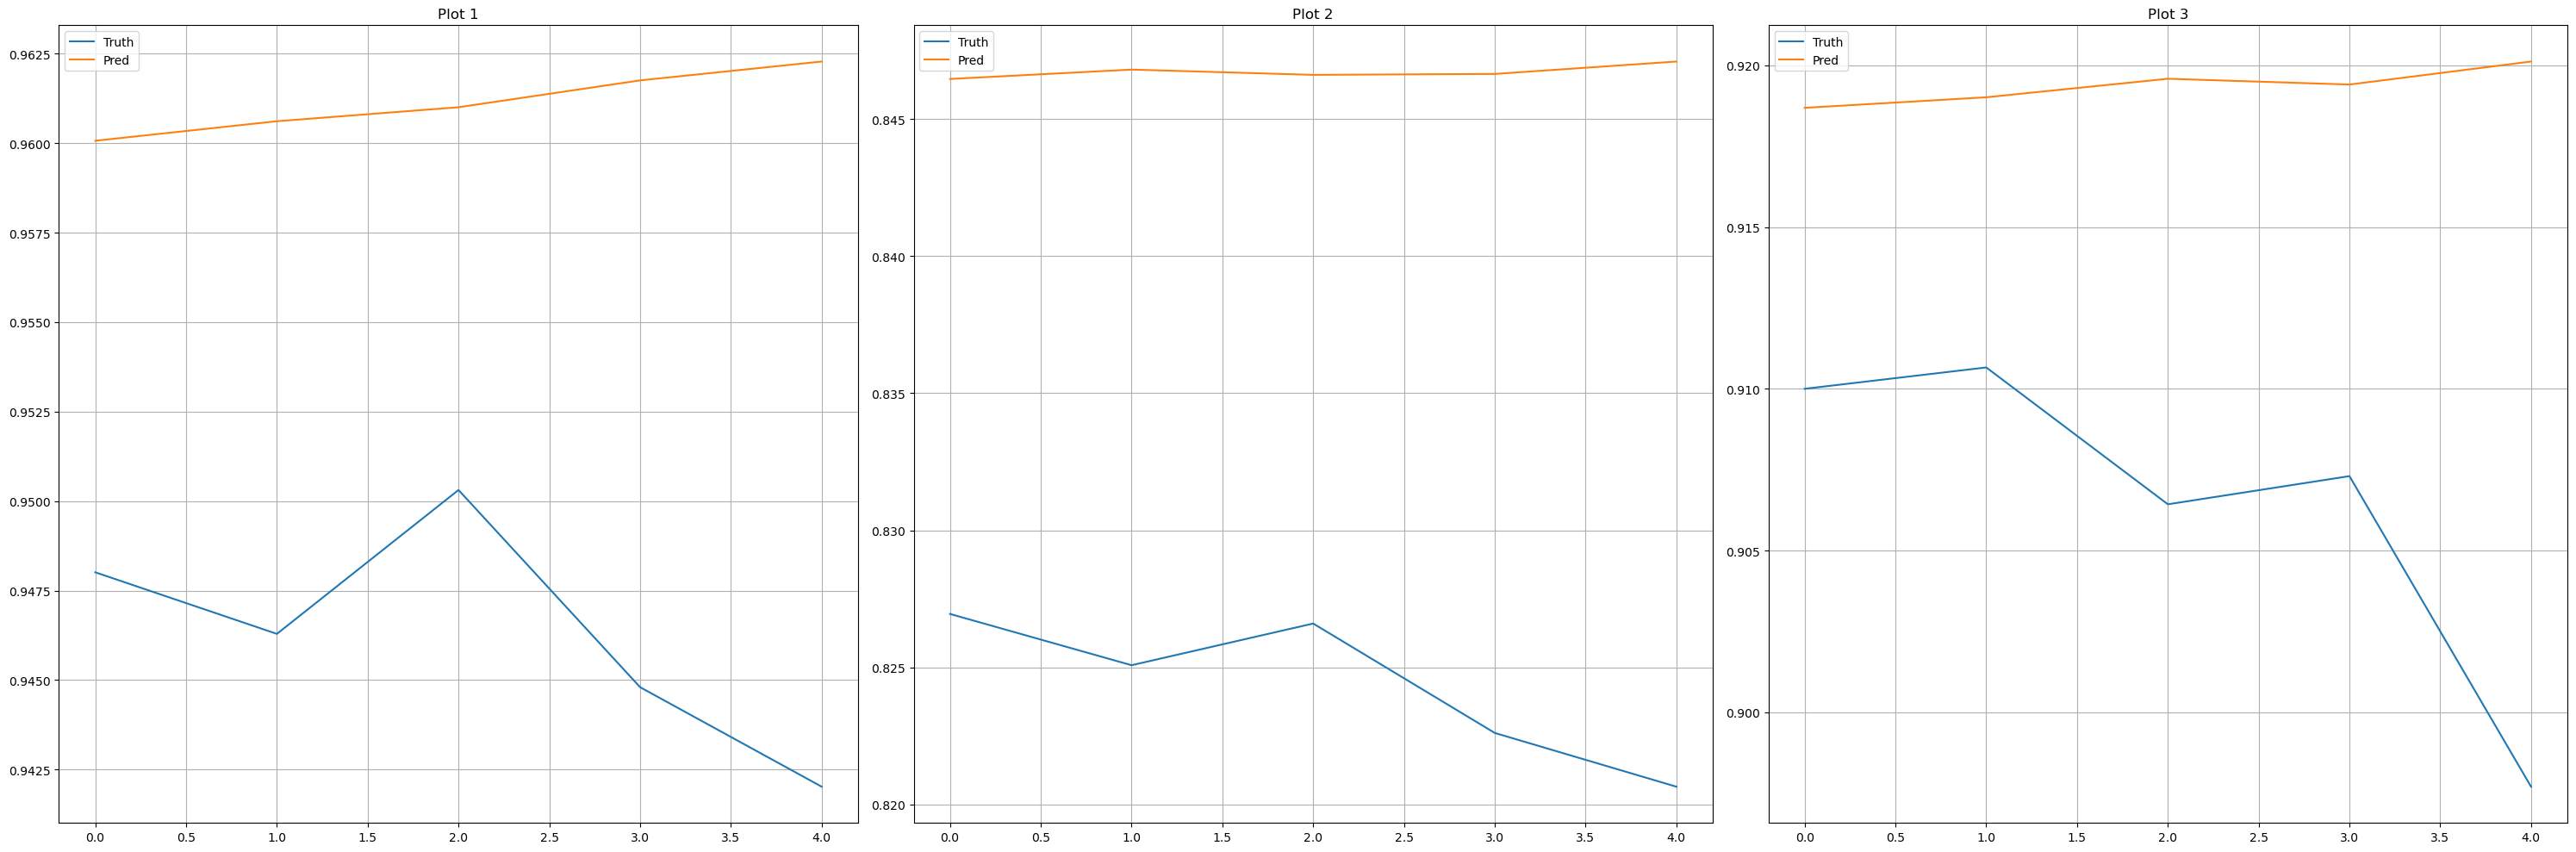

In [23]:
prophet_models = []

for curve_data in df_train_prophet:
    model = Prophet(
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.01,
        holidays_prior_scale=0.1
    )
    model.fit(curve_data)

    last_date = datetime.strptime(curve_data['ds'].max(), '%Y-%m-%d')
    # Create a date range for the next 5 trading days, excluding weekends
    future_dates = pd.date_range(start=last_date+timedelta(1), periods=5, freq='B')
    # Create a DataFrame with these dates
    future_df = pd.DataFrame({'ds': future_dates})
    # Make predictions
    forecast = model.predict(future_df)
    # Store the model and its forecast in a list
    prophet_models.append((model, forecast))

truth_prophet = [df_test_prophet[i]['y'].to_numpy() for i in range(len(df_test_prophet))]
pred_prophet = [prophet_models[i][1]['yhat'].to_numpy() for i in range(len(prophet_models))]
draw_pred_truth(truth_prophet, pred_prophet)

# ARIMA

In [24]:
#split train_dataset into train_dataset and validation_dataset, we set validation_dataset size to be 5, which conforms to test_dataset size
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

In [25]:
print(train.shape,val.shape)

(2597,) (5,)


In [26]:
# train ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Since we have already applied difference on data, we set d=0 here.
p,d,q=1,2,1
model = ARIMA(train, order=(p, d, q))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2597
Model:                 ARIMA(1, 2, 1)   Log Likelihood               10686.541
Date:                Sat, 04 Nov 2023   AIC                         -21367.082
Time:                        21:03:03   BIC                         -21349.498
Sample:                             0   HQIC                        -21360.710
                               - 2597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1177      0.015      7.650      0.000       0.088       0.148
ma.L1         -0.9999      0.119     -8.417      0.000      -1.233      -0.767
sigma2      1.541e-05   1.82e-06      8.462      0.0

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
train

array([0.74377, 0.74351, 0.74246, ..., 0.94993, 0.94977, 0.94645])

In [28]:
# prediction
train_predictions = result.predict(start=1, end=train.shape[0])
print(train_predictions)

val_predictions = result.get_forecast(len(val)).predicted_mean
print(val_predictions)

[1.115655   0.74325    0.74175849 ... 0.95007694 0.9498296  0.94612226]
[0.94612226 0.94614683 0.94621289 0.94628383 0.94635534]


In [29]:
val

array([0.94591, 0.9448 , 0.94636, 0.95   , 0.9491 ])

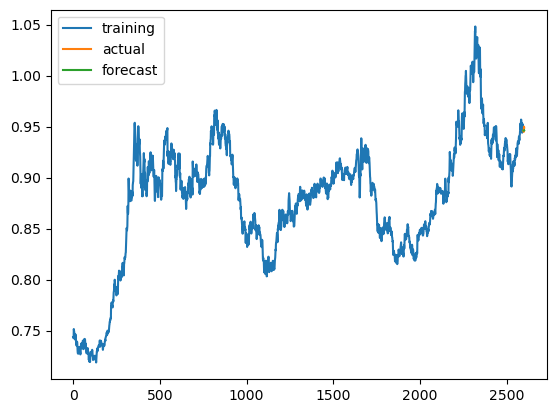

In [30]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

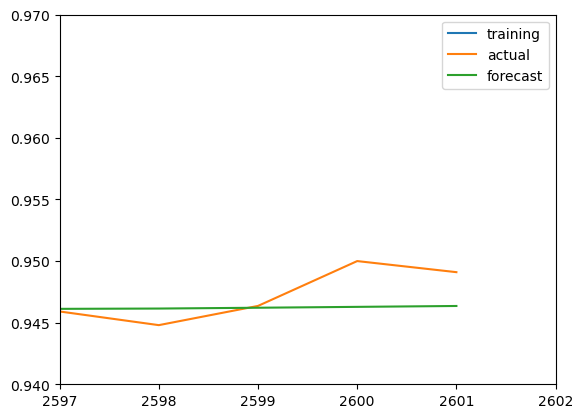

In [31]:
plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.xlim(len(train), len(train)+len(val))
plt.ylim(0.94, 0.97)
plt.legend()

In [32]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(train_predictions,train)
val_mse = mean_squared_error(val_predictions, val)

print("train_MSE:", train_mse)
print("val_MSE:", val_mse)

train_MSE: 5.3528762646226654e-05
val_MSE: 4.644757180041219e-06


## Fine-tuning

In [33]:
#gird search
min_val_mse=1e9
optimal_p=1
optimal_d=1
optimal_q=1
for p in range(1,6):
    for d in range(1,3):
        for q in range(1,6):
            model = ARIMA(train, order=(p, d, q))
            result = model.fit()
            train_predictions = result.predict(start=1, end=train.shape[0])
            val_predictions = result.get_forecast(len(val)).predicted_mean
            train_mse = mean_squared_error(train_predictions,train)
            val_mse = mean_squared_error(val_predictions, val)
            if (val_mse<min_val_mse):
                min_val_mse=val_mse
                optimal_p=p
                optimal_q=q
                optimal_d=d
            print(f"p={p},d={d},q={q}:")
            print("train_MSE:", train_mse)
            print("val_MSE:", val_mse)
            print("-------------------------------------------------------------")

p=1,d=1,q=1:
train_MSE: 2.362663161347601e-07
val_MSE: 5.242041572713077e-06
-------------------------------------------------------------
p=1,d=1,q=2:
train_MSE: 2.4029270995463554e-07
val_MSE: 5.249978621158124e-06
-------------------------------------------------------------
p=1,d=1,q=3:
train_MSE: 2.4976050237083627e-07
val_MSE: 5.007602154572877e-06
-------------------------------------------------------------
p=1,d=1,q=4:
train_MSE: 2.555596485556648e-07
val_MSE: 5.2183535303517386e-06
-------------------------------------------------------------
p=1,d=1,q=5:
train_MSE: 2.5738175602902587e-07
val_MSE: 5.3132760447041744e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1,d=2,q=1:
train_MSE: 5.3528762646226654e-05
val_MSE: 4.644757180041219e-06
-------------------------------------------------------------
p=1,d=2,q=2:
train_MSE: 5.551023009392525e-05
val_MSE: 1.7129423734798224e-05
-------------------------------------------------------------
p=1,d=2,q=3:
train_MSE: 5.4681079696365935e-05
val_MSE: 7.990360300768063e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=1,d=2,q=4:
train_MSE: 5.454378906431642e-05
val_MSE: 6.962253195368732e-06
-------------------------------------------------------------
p=1,d=2,q=5:
train_MSE: 5.435049161681586e-05
val_MSE: 5.152675207641163e-06
-------------------------------------------------------------
p=2,d=1,q=1:
train_MSE: 2.476942489173709e-07
val_MSE: 4.856416410503999e-06
-------------------------------------------------------------
p=2,d=1,q=2:
train_MSE: 2.7724360776727333e-07
val_MSE: 5.105229753679457e-06
-------------------------------------------------------------
p=2,d=1,q=3:
train_MSE: 2.5427398310368563e-07
val_MSE: 5.2039435406650795e-06
-------------------------------------------------------------
p=2,d=1,q=4:
train_MSE: 2.593064747420037e-07
val_MSE: 5.361487186246434e-06
-------------------------------------------------------------
p=2,d=1,q=5:
train_MSE: 2.5788325138429484e-07
val_MSE: 5.3449580093116405e-06
-------------------------------------------------------------
p=2,d=2,q=1:
train_MSE

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=3,d=1,q=2:
train_MSE: 2.4359130608360744e-07
val_MSE: 5.127849144615679e-06
-------------------------------------------------------------
p=3,d=1,q=3:
train_MSE: 2.6707071561063814e-07
val_MSE: 5.435477407991327e-06
-------------------------------------------------------------
p=3,d=1,q=4:
train_MSE: 2.6573487736690063e-07
val_MSE: 5.2431885226752315e-06
-------------------------------------------------------------
p=3,d=1,q=5:
train_MSE: 2.618318381086804e-07
val_MSE: 5.245745746612371e-06
-------------------------------------------------------------
p=3,d=2,q=1:
train_MSE: 5.7162122959399145e-05
val_MSE: 3.409078431947819e-05
-------------------------------------------------------------
p=3,d=2,q=2:
train_MSE: 5.553050848666303e-05
val_MSE: 1.7732643362344728e-05
-------------------------------------------------------------
p=3,d=2,q=3:
train_MSE: 5.478984523725312e-05
val_MSE: 9.977902818097458e-06
-------------------------------------------------------------
p=3,d=2,q=4:
train_MS

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=1,q=1:
train_MSE: 2.593803854138284e-07
val_MSE: 5.304205611824616e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=1,q=2:
train_MSE: 2.505050083966586e-07
val_MSE: 5.2757143068221464e-06
-------------------------------------------------------------
p=4,d=1,q=3:
train_MSE: 2.636776970305056e-07
val_MSE: 5.261467016840671e-06
-------------------------------------------------------------
p=4,d=1,q=4:
train_MSE: 2.6994388200591154e-07
val_MSE: 5.23794216922559e-06
-------------------------------------------------------------
p=4,d=1,q=5:
train_MSE: 2.750897576017255e-07
val_MSE: 5.557352045212204e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=4,d=2,q=1:
train_MSE: 5.3956380387421705e-05
val_MSE: 2.969516939397931e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=2:
train_MSE: 5.3464849293630074e-05
val_MSE: 3.6302695609898113e-06
-------------------------------------------------------------
p=4,d=2,q=3:
train_MSE: 5.488644736206366e-05
val_MSE: 1.2050189735771926e-05
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p=4,d=2,q=4:
train_MSE: 5.446801876471931e-05
val_MSE: 2.8326961955832523e-06
-------------------------------------------------------------
p=4,d=2,q=5:
train_MSE: 5.39923558067252e-05
val_MSE: 2.749648198178749e-06
-------------------------------------------------------------
p=5,d=1,q=1:
train_MSE: 2.5930269531785047e-07
val_MSE: 5.283317499210872e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=2:
train_MSE: 2.5085227457074413e-07
val_MSE: 5.3041021253480295e-06
-------------------------------------------------------------
p=5,d=1,q=3:
train_MSE: 2.637883284794673e-07
val_MSE: 5.2519577904968046e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=4:
train_MSE: 2.1475726127322644e-16
val_MSE: 4.529457792779333e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=1,q=5:
train_MSE: 3.789773595275808e-16
val_MSE: 4.5294643867807134e-06
-------------------------------------------------------------
p=5,d=2,q=1:
train_MSE: 5.629287047524988e-05
val_MSE: 9.804157802562719e-06
-------------------------------------------------------------
p=5,d=2,q=2:
train_MSE: 5.503507920679398e-05
val_MSE: 1.2300051682454465e-05
-------------------------------------------------------------
p=5,d=2,q=3:
train_MSE: 5.4754997655539633e-05
val_MSE: 9.413051608615327e-06
-------------------------------------------------------------


C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p=5,d=2,q=4:
train_MSE: 5.377122357424907e-05
val_MSE: 4.094072106618304e-06
-------------------------------------------------------------
p=5,d=2,q=5:
train_MSE: 5.435069740477258e-05
val_MSE: 5.546198873410287e-06
-------------------------------------------------------------


In [34]:
print(optimal_p,optimal_d,optimal_q)

4 2 5


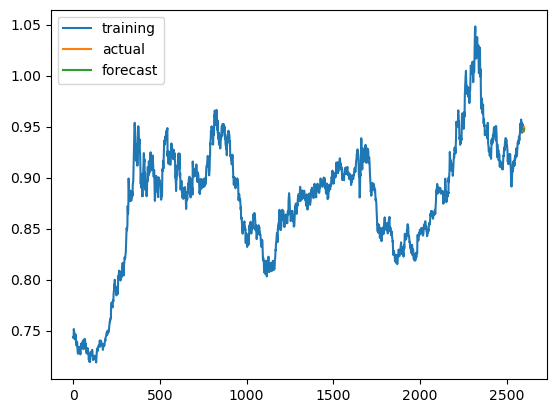

In [35]:
#visualize the best case
model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
result = model.fit()

train_predictions = result.predict(start=1, end=train.shape[0])
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Modularization

In [36]:
def fine_tune(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
    min_val_mse=1e9
    optimal_p=1
    optimal_d=1
    optimal_q=1
    for p in range(1,6):
        for d in range(1,3):
            for q in range(1,6):
                model = ARIMA(train, order=(p, d, q))
                result = model.fit()
                train_predictions = result.predict(start=1, end=train.shape[0])
                val_predictions = result.get_forecast(len(val)).predicted_mean
                train_mse = mean_squared_error(train_predictions,train)
                val_mse = mean_squared_error(val_predictions, val)
                if (val_mse<min_val_mse):
                    min_val_mse=val_mse
                    optimal_p=p
                    optimal_q=q
                    optimal_d=d
    
    return optimal_p,optimal_d,optimal_q

In [37]:
#find best hyper parameters for each dataset
best_parameters=[]
for i in range(len(filepath)):
    best_parameters.append(fine_tune(df_train[i]))

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization

C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarni

In [38]:
print(best_parameters)

[(4, 2, 5), (3, 1, 3), (5, 1, 5)]


In [39]:
def get_best_model(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model = ARIMA(train, order=(optimal_p, optimal_d, optimal_q))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

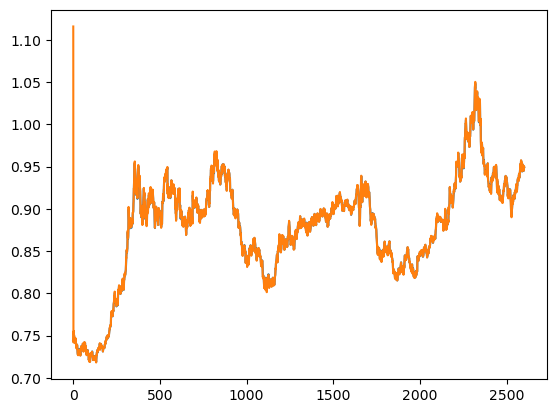

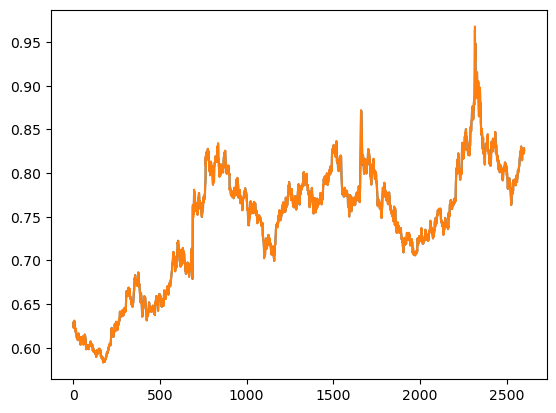

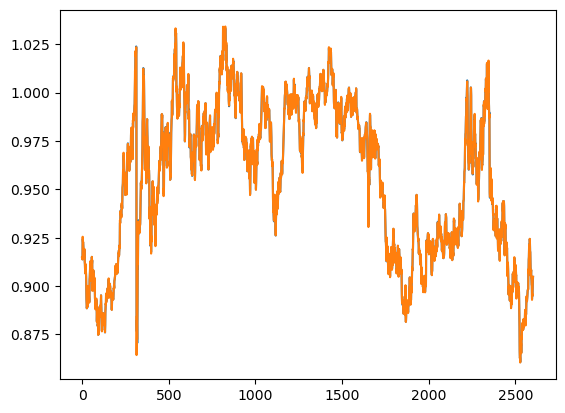

In [40]:
models=[]
for i in range(len(filepath)):
    models.append(get_best_model(df_train[i],best_parameters[i]))

## Compute Max Profit

In [41]:
ARIMA_predictions=[]
for i in range(len(filepath)):
    ARIMA_predictions.append(models[i].get_forecast(len(df_test[i])).predicted_mean)

In [42]:
ARIMA_predictions=np.array(ARIMA_predictions)
ARIMA_predictions

array([[0.94942979, 0.94960663, 0.94962632, 0.95014073, 0.95049041],
       [0.82588942, 0.82581025, 0.82571874, 0.82568566, 0.82566393],
       [0.9048328 , 0.90488881, 0.90509672, 0.90500891, 0.90476318]])

In [43]:
true_rate=[]
for i in range(len(filepath)):
    true_rate.append(np.array(df_test[i]).squeeze())

In [44]:
true_rate=np.array(true_rate)
true_rate

array([[0.94801, 0.94629, 0.95031, 0.9448 , 0.94202],
       [0.82695, 0.82508, 0.8266 , 0.82261, 0.82065],
       [0.91   , 0.91066, 0.90643, 0.9073 , 0.8977 ]])

In [45]:
def get_max_profit(rate):
    #We initially have 1000 dollars
    principal=1000
    # 5 days in total, we have 4 chances to make a profit
    for i in range(4):
        #Here, we initialize rate_increase to be 1. This is to prevent elements in rate_increase are all smaller than 1.
        rate_increase=np.array([1])
        #Here, we only need the first three predictions.
        for j in range(3):
            rate_increase=np.append(rate_increase,rate[j][i+1]/rate[j][-1])
        max_rate_increase=np.max(rate_increase)
        principal*=max_rate_increase
    return principal

In [46]:
predict_profit=get_max_profit(ARIMA_predictions)
true_profit=get_max_profit(true_rate)
print(predict_profit,true_profit)

1000.817671981051 1035.256026137118


In [47]:
#Compute MSE between the max profit computed via ARIMA and the actual profit 
profit_mse = (predict_profit-true_profit)**2
print("MSE between the max profit computed via ARIMA and the actual profit is:", profit_mse)

MSE between the max profit computed via ARIMA and the actual profit is: 1186.0002369786907


# SARIMA

In [48]:
#seperates data set
train_size=len(df_train[0][:-5])

train=np.array(df_train[0]['rate'])[:train_size]
val=np.array(df_train[0]['rate'])[train_size:]

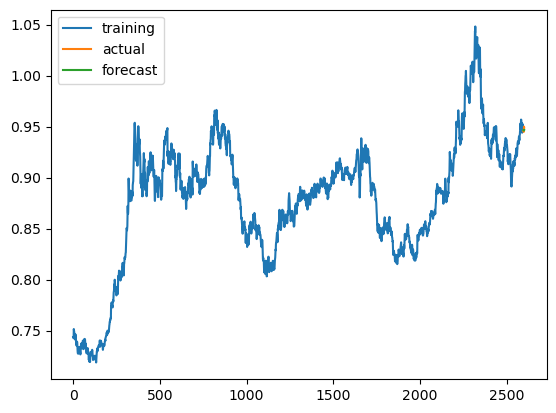

In [49]:
# train SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# initial parameters
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,1,1,12))
result = sarima.fit()
train_prediction = result.predict()
val_predictions = result.get_forecast(len(val)).predicted_mean

plt.plot(train,label='training')
plt.plot(range(len(train),len(train)+len(val)),val,label='actual')
plt.plot(range(len(train),len(train)+len(val)),val_predictions,label='forecast')
plt.legend()

## Error Calculation

In [50]:
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(result.predict(),train)
val_mse = mean_squared_error(val_predictions, val)

## Fine tuning

In [55]:
def get_best_model_sarima(df,best_parameter):
    #train using the whole training dataset
    train=np.array(df['rate'])

    
    #visualize the best case
    optimal_p, optimal_d, optimal_q=best_parameter
    model =  SARIMAX(train, order=(optimal_p, optimal_d, optimal_q), seasonal_order=(p,d,q,12))
    result = model.fit()

    train_predictions = result.predict(start=1, end=train.shape[0])

    plt.plot(train,label='training')
    plt.plot(train_predictions,label='train_prediction')
    plt.show()

    return result

In [56]:
def fine_tune_sarima(df):
    #split dataset
    train_size=len(df[:-5])

    train=np.array(df['rate'])[:train_size]
    val=np.array(df['rate'])[train_size:]
    
    #fine-tuning
                    
    q_optimized = 0
    d_optimized = 0
    p_optimized = 0

    smallest_error = -1
    for q in range(1, 3):
        for d in range(1, 3):
            for p in range(1, 3):
                sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(p,d,q,12))
                sarima_model.fit()
                train_prediction = result.predict()
                val_predictions = result.get_forecast(len(val)).predicted_mean
                if (smallest_error == -1):
                    smallest_error = mean_squared_error(val_predictions, val)
                else:
                    err = mean_squared_error(val_predictions, val)
                    if (err < smallest_error):
                        smallest_error = err
                        q_optimized = q
                        d_optimized = d
                        p_optimized = p
    
    return p_optimized,d_optimized,q_optimized

C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelih

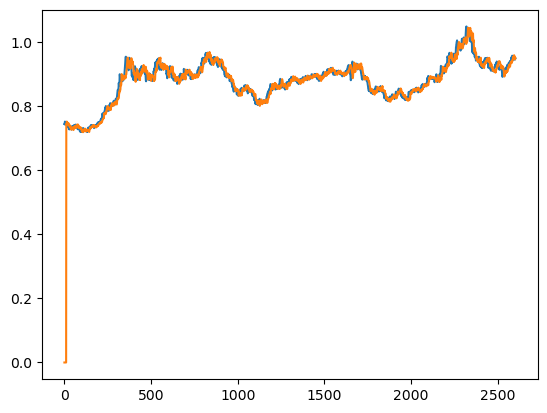

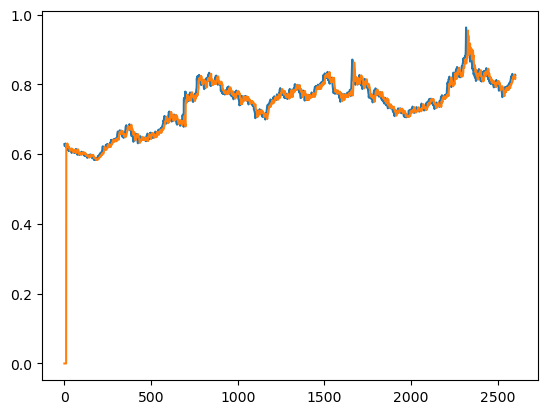

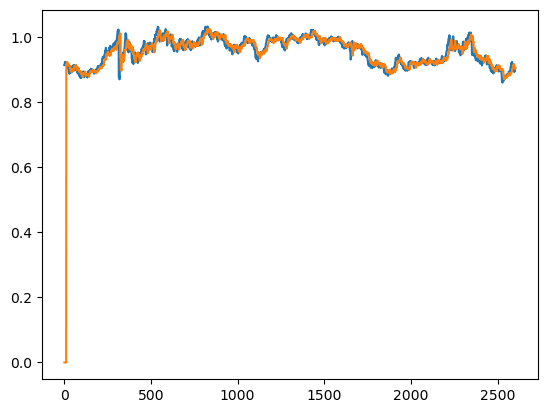

In [57]:
#find best hyper parameters for each dataset
best_parameters_sarima=[]
for i in range(3):
    best_parameters_sarima.append(fine_tune_sarima(df_train[i]))

models_sarima=[]
for i in range(3):
    models_sarima.append(get_best_model_sarima(df_train[i],best_parameters_sarima[i]))


In [58]:
SARIMA_predictions=[]
for i in range(3):
    SARIMA_predictions.append(models_sarima[i].get_forecast(len(df_test[i])).predicted_mean)

# Model Assembling

In [63]:
pred_prophet=np.array(pred_prophet)
pred_prophet

array([[0.96006805, 0.96061385, 0.96100468, 0.96175484, 0.96228176],
       [0.84645936, 0.84680116, 0.84660925, 0.84664327, 0.84709535],
       [0.91868523, 0.91901172, 0.91958416, 0.91940545, 0.92011661]])

In [60]:
ARIMA_predictions

array([[0.94942979, 0.94960663, 0.94962632, 0.95014073, 0.95049041],
       [0.82588942, 0.82581025, 0.82571874, 0.82568566, 0.82566393],
       [0.9048328 , 0.90488881, 0.90509672, 0.90500891, 0.90476318]])

In [65]:
SARIMA_predictions=np.array(SARIMA_predictions)
SARIMA_predictions

array([[0.95003016, 0.95505392, 0.95405481, 0.95179872, 0.95263475],
       [0.81935185, 0.82395596, 0.82339074, 0.82377255, 0.8239045 ],
       [0.90621699, 0.90362163, 0.90198272, 0.90003658, 0.89923931]])

In [72]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

for i in range(len(filepath)):
    x1=pred_prophet[i]
    x2=ARIMA_predictions[i]
    x3=SARIMA_predictions[i]

    X_train = np.column_stack((x1, x2, x3))
    y_train = true_rate[i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)

weights = model.coef_

In [73]:
print(weights)

[-10.32942378  12.31368393  -0.36241275]
